# Computational Category Theoretic Rewriting 
### Kris Brown, Evan Patterson, Tyler Hanks, and James Fairbanks
This notebook accompanies the above paper, showing the code behind the scenes for each of the main figures.
We start with imports.

In [1]:
using Pkg; Pkg.activate("/Users/ksb/code/Computational-Category-Theoretic-Rewriting")
#using Revise, Catlab.CategoricalAlgebra, Catlab.Graphs, Catlab.Present, Catlab.Graphics, Catlab.Theories
#import Catlab
#import Catlab.CategoricalAlgebra.CatElements
#using Catlab.CategoricalAlgebra.FinCats: FinCatGraphEq
#using CombinatorialSpaces
#using CombinatorialSpaces.SimplicialSets: get_edge!
#import AlgebraicPetri


  Activating project at `~/code/Computational-Category-Theoretic-Rewriting`


In [2]:
using Base.Iterators
using CairoMakie, GeometryBasics
using CombinatorialSpaces
import AlgebraicPetri
using CombinatorialSpaces.SimplicialSets: get_edge!
using Catlab.CategoricalAlgebra, Catlab.Graphs, Catlab.Present, Catlab.Graphics, Catlab.Theories
using Catlab.CategoricalAlgebra.FinCats: FinCatGraphEq
import Catlab 
pres = Catlab.CategoricalAlgebra.CatElements.presentation; # abbreviate long name

┌ Info: Precompiling CombinatorialSpaces [b1c52339-7909-45ad-8b6a-6e388f7c67f2]
└ @ Base loading.jl:1423
┌ Info: Precompiling AlgebraicPetri [4f99eebe-17bf-4e98-b6a1-2c4f205a959b]
└ @ Base loading.jl:1423


## Figure 1

In [3]:
G = @acset Graph begin 
    V=3; E=3; 
    src=[1,2,2]; 
    tgt=[2,3,3] 
end
to_graphviz(G; node_labels=true)

## Figure 2
The declaration of a new $\mathcal{C}$-set schema and an example instance of that schema.

In [4]:
@present ThSemisimplicialSet(FreeSchema) begin
  (V,E,T) :: Ob
  (d1,d2,d3)::Hom(T,E)
  (src,tgt) :: Hom(E,V)
  compose(d1, src) == compose(d2, src)
  compose(d1, tgt) == compose(d3, tgt)
  compose(d2, tgt) == compose(d3, src)
end
@acset_type SSet(ThSemisimplicialSet)

quadrangle = @acset SSet begin 
    T=2; E=5; V=4
    d1=[1,1]
    d2=[2,3]
    d3=[4,5]
    src=[1,1,1,2,3]
    tgt=[4,2,3,4,4]
end 

SSet with elements V = 1:4, E = 1:5, T = 1:2
┌───┬─────┬─────┐
│ E │ src │ tgt │
├───┼─────┼─────┤
│ 1 │   1 │   4 │
│ 2 │   1 │   2 │
│ 3 │   1 │   3 │
│ 4 │   2 │   4 │
│ 5 │   3 │   4 │
└───┴─────┴─────┘
┌───┬────┬────┬────┐
│ T │ d1 │ d2 │ d3 │
├───┼────┼────┼────┤
│ 1 │  1 │  2 │  4 │
│ 2 │  1 │  3 │  5 │
└───┴────┴────┴────┘

Thanks to Andrew Baas, we can visualize SSets with the following function:

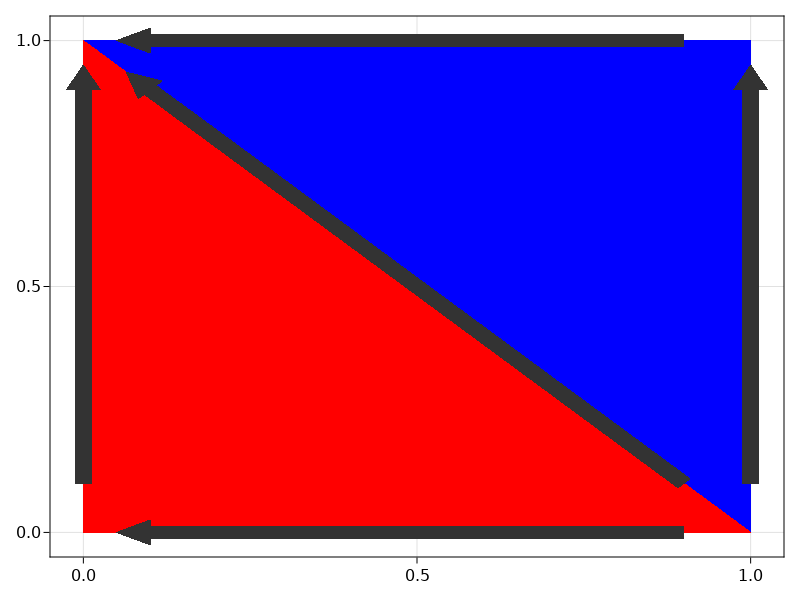

In [5]:
function plot_sset(ss::SSet, points::Vector, 
                   tri_colors::Union{Nothing,Vector}=nothing) 
    dflt = collect(take(cycle([:blue,:red,:green, :purple, :pink, :yellow, :grey, :orange, :brown, :cyan]), nparts(ss, :T)))
    tri_colors = isnothing(tri_colors) ? dflt : tri_colors
    # Validate inputs
    lengthscale=0.8
    dim = length(points[1])
    length(points) == nparts(ss,:V) || error("# of points")
    if dim == 2 
        points = [(p1,p2,0.) for (p1,p2) in points]
    elseif dim != 3
        error("dim $dim")
    end
    tri_colors = tri_colors[1:nparts(ss, :T)]

    # Convert SSet to EmbeddedDeltaSet2D
    s = EmbeddedDeltaSet2D{Bool, Point{3, Float64}}()

    edge_colors = [:black for _ in nparts(ss, :E)]
    add_vertices!(s, length(points), point=points)
    for (src, tgt) in zip(ss[:src], ss[:tgt])
        get_edge!(s, src, tgt)
    end
    
    for t in parts(ss,:T)
    glue_sorted_triangle!(s, ss[t,[:d1,:src]],
                             ss[t,[:d3,:src]],
                             ss[t, [:d1,:tgt]])
    end

    # Split mesh into component triangles
  m = GeometryBasics.Mesh(s)
  x = faces(m)
  m_points = m.position[vcat([[t[1],t[2],t[3]] for t in x]...)]
  m_faces = TriangleFace{Int}[[((t-1) * 3) .+ (1,2,3) for t in  1:length(x)]...]
  new_m = GeometryBasics.Mesh(Point{3, Float64}[m_points...], m_faces)
  if ntriangles(s) == 0
     fig, ax, ob = arrows((s[s[:∂v0], :point] * (0.5 + lengthscale / 2) 
                            .+ s[s[:∂v1], :point] * (0.5 - lengthscale / 2)) , 
                          (s[s[:∂v1], :point] .- s[s[:∂v0], :point]), 
            lengthscale=lengthscale, arrowsize=0.05, shininess=0.0,
           color=edge_colors, diffuse=[0.0,0.0,0.0])
  else
    fig, ax, ob = mesh(new_m, color=vcat([[v,v,v] for v in tri_colors]...))
     arrows!((s[s[:∂v0], :point] * (0.5 + lengthscale / 2) 
                    .+ s[s[:∂v1], :point] * (0.5 - lengthscale / 2)) , 
             (s[s[:∂v1], :point] .- s[s[:∂v0], :point]), 
            lengthscale=lengthscale, arrowsize=0.05, shininess=0.0,
           color=edge_colors, diffuse=[0.0,0.0,0.0])
  end
  if dim == 2
      # hidespines!(ax); hidedecorations!(ax)
      ax.aspect = AxisAspect(1.0) # Remove this line if 3D embedding
  end 
  fig
end

quad_coords = [(0,1,0), (1,1,0), (0,0,0),(1,0,0)]
plot_sset(quadrangle, quad_coords)



## Figure 3a 
Catlab has functionality to reversibly translate between a $\mathcal{C}$-set and its category-of-elements representation (which is a $\mathcal{C}$-typed-graph).

NODE TYPES: [:V, :V, :V, :V, :E, :E, :E, :E, :E, :T, :T]


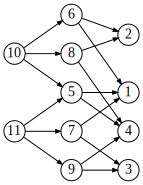

In [6]:
e = elements(quadrangle)
println("NODE TYPES: ", e[[:πₑ, :nameo]])
to_graphviz(FreeDiagram(pres(e)[1]), node_labels=true)

## Figure 4
We show a sequence of building schema `N+1` by choosing a designated instance of schema `N` and treating it as a type system.

In [7]:
G2 = @acset Graph begin V=2; E=2; src=[1,2]; tgt=[2,1] end 
ThPetri = pres(elements(G2))[1]
@acset_type Petri(ThPetri)
Interact = @acset Petri begin 
    V_1=2; V_2=3; E_1=4; E_2=4
    src_E_1 = [1,1,2,2]
    tgt_E_1 = [1,2,2,3]
    src_E_2 = [1,2,2,3]
    tgt_E_2 = [1,1,2,2]
end
ThHV = pres(elements(Interact))[1]
@acset_type HV(ThHV)  ;  
# etc. TODO visualize the acsets+schemas

## Figure 5
The benchmark code is also found in this repository, in the `src` folder.

## Figure 6
A single quadralateral edge flip with DPO rewriting. We first set up the objects involved in the rules and the object we will rewrite:

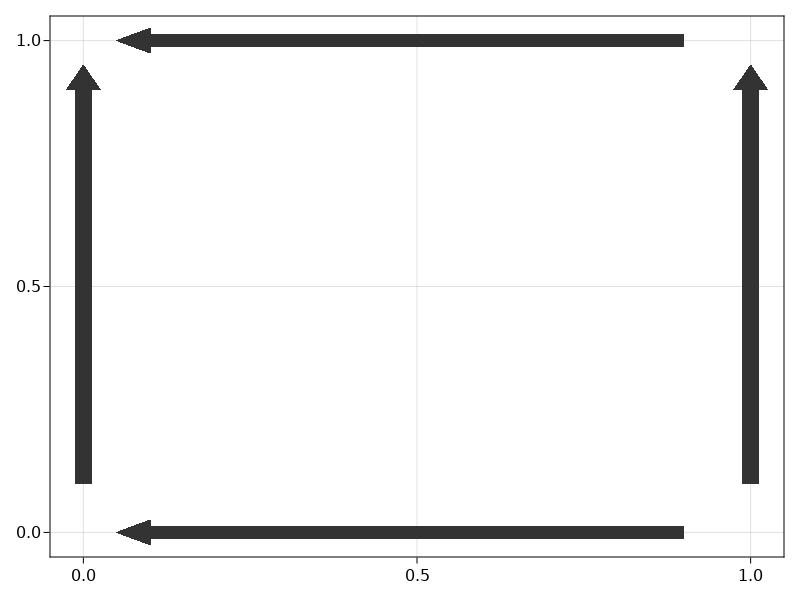

In [8]:
L = quadrangle  # We defined quadrilateral above.
I = @acset SSet begin
  E=4; V=4
  src=[1,1,2,3]
  tgt=[2,3,4,4]
end
plot_sset(I, quad_coords) 


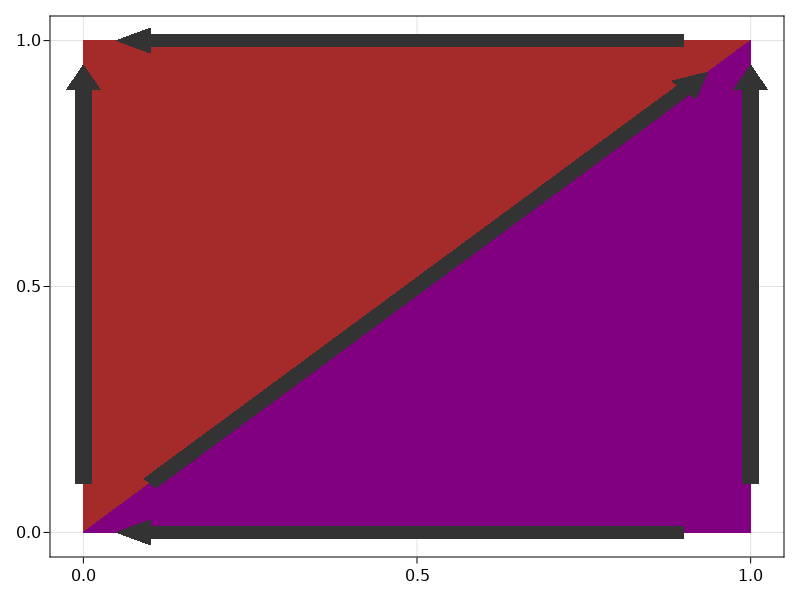

In [9]:
R = @acset SSet begin
  T=2; E=5; V=4
  d1=[2,3]
  d2=[1,5]
  d3=[5,4]
  src=[1,1,2,3,2]
  tgt=[2,3,4,4,3]
end
plot_sset(R, quad_coords, [:brown, :purple])

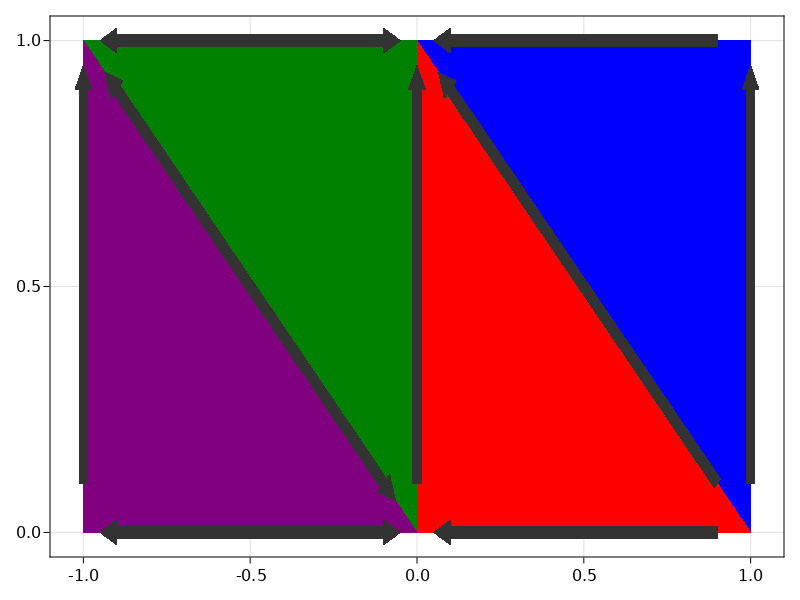

In [10]:
# construct G via pushout: glue two quads by a common edge
edge = @acset SSet begin E=1; V=2; src=[1]; tgt=[2] end 
edge_left = homomorphism(edge, L; initial=Dict([:V=>[1,3]]))
edge_right = homomorphism(edge, L; initial=Dict([:V=>[2,4]]))
G = apex(pushout(edge_left, edge_right)) 
six_coords = vcat(quad_coords,[(-1.,1.,0.),(-1.,0.,0.),])
plot_sset(G, six_coords)

Partially specify homomorphisms and let automated search handle the rest to generate the morphisms used in DPO.

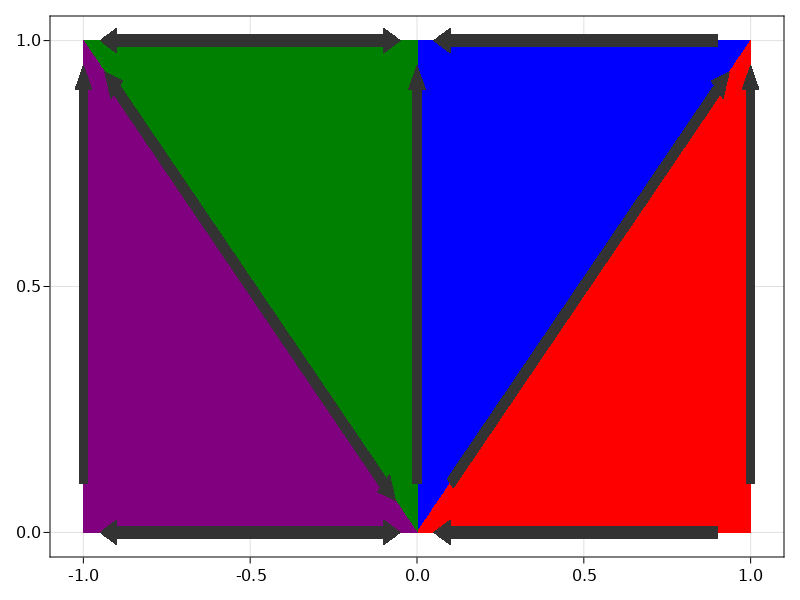

In [11]:
r = homomorphism(I, R; monic=true)
l = homomorphism(I, L; monic=true)
# Perform rewrite 
res =  rewrite(l, r, G; monic=true) # homomorphism search will find a match, if any
plot_sset(res, six_coords)

## Figure 7
Demonstrating single-pushout rewriting with implicit deletion.

In [12]:
Tri = @acset SSet begin 
    T=1; E=3; V=3; 
    d1=[1]; d2=[2]; d3=[3]; 
    src=[1,1,2]; tgt=[3,2,3] 
end
L = Tri
l = homomorphisms(edge, L)[2]
r = id(edge)
m = homomorphism(L, quadrangle)
can_pushout_complement(l, m)
!can_pushout_complement(l, m) || error("Check that this does not make sense for DPO")
single_pushout_rewrite(l,r,m)

E,src,tgt
1,1,2
2,1,3


### Figure 8
Demonstrating sesqui-pushout rewriting with implicit copying.

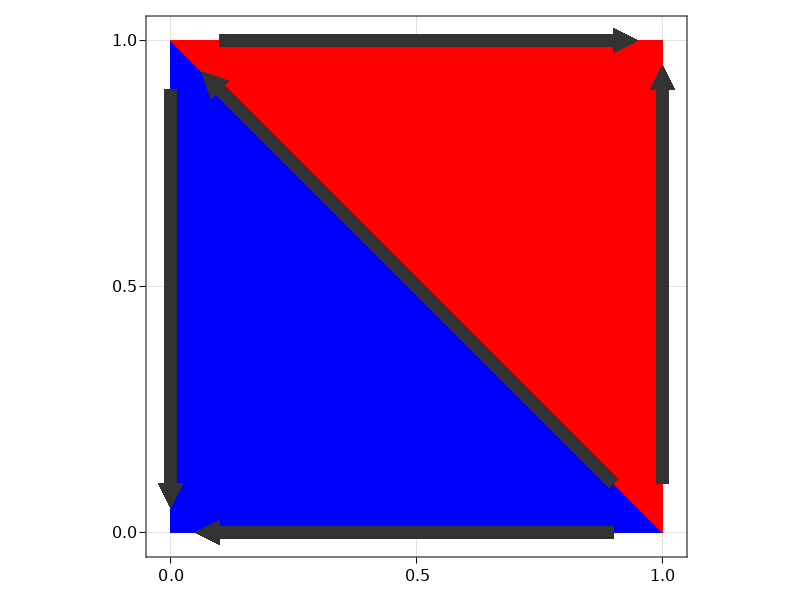

In [13]:
G = Tri
L = @acset SSet begin V=1 end
I = @acset SSet begin V=2 end
l = homomorphism(I,L); 
r=id(I); 
m = CSetTransformation(L, G, V=[1]);
nparts(sesqui_pushout_rewrite(l, r, m), :T) == 4 || error("We get 4 'triangles' when we ignore equations")
resSqPO= sesqui_pushout_rewrite(l, r, m; pres=ThSemisimplicialSet) # pass in the equations
plot_sset(resSqPO, [(0,0),(1,1),(0,1),(1,0),]) # only two triangles

## Figure 9
We highlight an aspect of directly rewriting in slice categories by computing the pushout complement of slices. We have special visualization written for Petri nets, so we define a function which migrates a morphism into the graph "2" to a Petri net. But our point is that the computations can be done entirely without moving into this larger schema.  

In [14]:
GraphSlice = Slice{Graph, ACSetTransformation}
GraphSliceMorphism = SliceMorphism{Graph, ACSetTransformation}

function graph_slice(s::GraphSlice) 
    h = s.slice
    V, E = collect.([h[:V], h[:E]])
    g = dom(h)
    (S,T), (I,O) = [[findall(==(i),X) for i in 1:2] for X in [V,E]]
    nS,nT,nI,nO = length.([S,T,I,O])
    findS, findT = [x->findfirst(==(x), X) for X in [S,T]]
    AlgebraicPetri.Graph(@acset AlgebraicPetri.PetriNet begin 
        S=nS; T=nT; I=nI; O=nO
        is=findS.(g[I,:src]); it=findT.(g[I, :tgt])
        ot=findT.(g[O,:src]); os=findS.(g[O, :tgt]) end)
end;

Then we can set up our rewrite problem (given the slice constraint, there is only ever one choice for a map between slices, so we just visualize the objects)

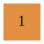

In [15]:
two = @acset Graph begin V=2; E=2; src=[1,2]; tgt=[2,1] end # V1 = (S), V2 = [T]
I_ = Graph(1)
I = GraphSlice(ACSetTransformation(I_, two, V=[2])) # a transition [T]
graph_slice(I)

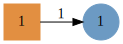

In [16]:
L_ = path_graph(Graph, 2)
L = GraphSlice(ACSetTransformation(L_, two, V=[2,1], E=[2])) # [T] ⟶ (S)
l = GraphSliceMorphism(I,L,ACSetTransformation(I_,L_,V=[1]))
graph_slice(L)

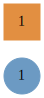

In [17]:
R_ = Graph(2)
R = GraphSlice(ACSetTransformation(R_, two, V=[2, 1])) # a transition and state [T] (S)
r = GraphSliceMorphism(I,R,ACSetTransformation(I_, R_, V=[1]))
graph_slice(R)

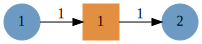

In [18]:
G_ = path_graph(Graph, 3)
G = GraphSlice(ACSetTransformation(G_, two, V=[1,2,1], E=[1,2])) # (S) ⟶ [T] ⟶ (S)
m = GraphSliceMorphism(L,G,ACSetTransformation(L_,G_,V=[2,3], E=[2]))
graph_slice(G)

Now we compute the rewrite in the slice category:

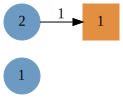

In [19]:
graph_slice(rewrite_match(l, r, m))

## Figure 10
We show an example of computing DPO on structured cospans of Graphs, where the interface type is the discrete graph. We start with an open square, where 1 is the designated input and 2 is the designated output.

input [1] output [2]


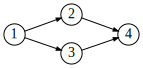

In [20]:
const OpenGraphOb, OpenGraph = OpenCSetTypes(Graph, :V)

# Some basic graphs and morphisms 
G1, G2, G3 = Graph.([1,2,3])
Arrow = path_graph(Graph, 2)
id_1 = id(Graph(1));
f12 = CSetTransformation(G1, G2, V=[1]);
f22 = CSetTransformation(G1, G2, V=[2]);
up_ = ACSetTransformation(G2, Arrow, V=[1,2]);
down_ = ACSetTransformation(G2, G1, V=[1,1]);

# Graph to rewrite
Square = @acset Graph begin V=4; E=4; src=[1,1,2,3]; tgt=[2,3,4,4] end
opensquare = OpenGraph(Square, FinFunction([1], 4), FinFunction([2], 4));

println("input ", collect(first(legs(opensquare))[:V]), 
        " output ", collect(last(legs(opensquare))[:V]),)
to_graphviz(apex(opensquare), node_labels=true)


We then match a rule which squashes an edge into a point, creating an open triangle.

input [1] output [1]


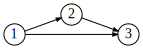

In [21]:
# Discrete open graphs
o1 = OpenGraph(G1, id_1[:V], id_1[:V]);
o2 = OpenGraph(G2, f12[:V], f22[:V]);

# Open graph with an edge 
openarr = OpenGraph(Arrow, f12[:V], f22[:V]);


# Map from discrete 2 point graph to an arrow, so we delete the arrow
squash_l = StructuredMultiCospanHom(o2, openarr,
  ACSetTransformation[up_, id_1, id_1])

# Map from discrete 2 point graph to the discrete 1 point graph
squash_r = StructuredMultiCospanHom(o2, o1,
  ACSetTransformation[down_, id_1, id_1])

# Putting together the two legs of the rule
squash = openrule(Span(squash_l, squash_r))

# match arrow to square edge that has an input and an output
square_m = StructuredMultiCospanHom(openarr, opensquare,
  ACSetTransformation[
        ACSetTransformation(Arrow, Square, V=[1,2], E=[1]), 
  id_1, id_1])

# Input and output now merged
res = open_rewrite_match(squash, square_m)
println("input ", collect(first(legs(res))[:V]), 
        " output ", collect(last(legs(res))[:V]),)
to_graphviz(apex(res), node_labels=true)


## Figure 11
We show the construction of a cube surface as a distributed semi-simplicial set. Start by defining the category of distributed Semisimplicial Sets as a special kind of diagram


In [22]:
const ACSetCat{S} = TypeCat{S, ACSetTransformation}
const DistSSet{D} = Diagram{id, ACSetCat{SSet}, D}
const DistSSetHom{F,Φ,D} = DiagramHom{id, ACSetCat{SSet}, F, Φ, D};

We then specify the data of the network graph and declare its path to commute. 

In [23]:
""" 
Helper fn: category generated by a finite graph where all paths commute.
"""

dsrc = [2,2,3,3, 5,5, 6,6, 7,7, 8,8, 9,9, 11,11,13,13,15,15,16,16,17,17]
dtgt = [1,4,1,10,1,14,4,10,4,12,4,14,1,18,10,12,12,14,10,18,12,18,14,18]
d = @acset Graph begin 
    V=6+12;  # faces, edges: numbering comes from the figure →,↓
    E=24;    # each face glued along four edges
    src=dsrc
    tgt=dtgt
end;

es = [i for (i, e) in enumerate(dsrc) if e in vcat([2,3,5,9,7,11,13,16],[8,15, 6, 17])] 
# 8 is good (lowers vertices from 16->14), 15 is good (lowers to 12)
# 6 is good (lowers to 10)

d_ = FinCatGraph(@acset Graph begin 
    V=6+12;  # faces, edges: numbering comes from the figure →,↓
    E=length(es);    # each face glued along four edges
    src=dsrc[es]
    tgt=dtgt[es]
    end;)
D = FinCatGraph(d);
#to_graphviz(d, node_labels=true)

Lastly, we construct the functor into the category of semisimplicial complexes


In [24]:

# SSets corresponding to the vertices
obs = repeat([edge], 18)
obs[[1,4,10,12,14,18]] .= repeat([quadrangle], 6)

# Use homomorphism finder to get all of the relevant morphisms
_, purple, red, teal, green = homomorphisms(edge, quadrangle) # TODO: actually get this right

# SSet morphisms corresponding to the edges of the diagram
homs = [green, green,  # E2
        red, teal,    # E3
        teal, teal,   # E5
        red, green,     # E6
        purple, green,# E7
        teal, green,     # E8
        purple, green, # E9
        red, red,   # E11
        teal, red,  # E13
        purple, red,     # E15
        purple, purple, # E16
        purple, teal]     # E17
FF = FinDomFunctor(obs, homs, D)
@assert is_functorial(FF)
J = FreeDiagram(FF); 


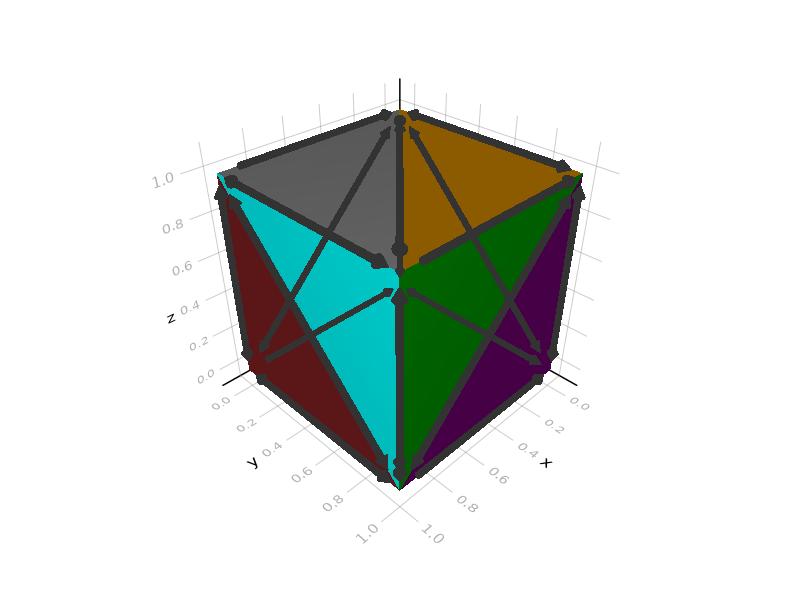

In [25]:
cube = apex(colimit(J));
cube_coords = vcat(quad_coords, [(0,1,1), (1,1,1), (0,0,1),(1,0,1)])
display(plot_sset(cube, cube_coords))

## Further extensions
We start with parallel rewriting. We delete three self loops in parallel.

In [26]:
t = apex(terminal(Graph))
G = t ⊕ t ⊕ t
to_graphviz(G)


In [27]:
L = homomorphism(Graph(1), t)
rule = Rule(L,id(Graph(1)))
to_graphviz(apply_parallel_rule(rule, G))


This rewrite rule matches a span of arrows and removes the edges.

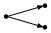

In [28]:
l = @acset Graph begin V=3; E=2; src=[1,1]; tgt=[2,3] end
L = homomorphism(Graph(3), l; monic=true); R=id(Graph(3))
to_graphviz(l)

The pattern has 6 possible matches (given a `monic` constraint), but only one can be run in parallel.

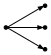

In [29]:
G = @acset Graph begin V=4; E=3; src=[1,1,1]; tgt=[2,3,4] end
to_graphviz(G)

So we expect one edge remaining from applying the rule in parallel.

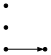

In [30]:
to_graphviz(apply_parallel_rule(Rule(L,R), G; monic=true))

Negative application conditions allow us to restrict us from deleting edges that are pointing to something with a self loop, for example.

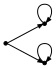

In [31]:
n = @acset Graph begin V=3; E=4; src=[1,1,2,3]; tgt=[2,3,2,3] end
N = homomorphism(l,n; monic=true)
to_graphviz(n) # this pattern is forbidden in a match

Now we'll modify `G` to have self loops on all but one of the edges. With the monic constraint, there are no longer any possible matches.

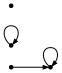

In [32]:
G = @acset Graph begin V=4; E=5; src=[1,1,1,2,3]; tgt=[2,3,4,2,3] end
#@assert is_isomorphic(apply_parallel_rule(Rule(L,R,N), G; monic=true), G)
to_graphviz(apply_parallel_rule(Rule(L,R,N), G; monic=true))

We last show some rewriting with attributes (Attributed C-Sets, or ACSets). We'll define a graph with weights on edges. (note, visualization will not show the weights on the edges by default)

In [33]:
using Catlab.Graphs.BasicGraphs: TheoryGraph
@present TheoryLabeledGraph <: TheoryGraph begin
  (Weight)::AttrType
  weight::Attr(E,Weight)
end
@acset_type LabeledGraph(TheoryLabeledGraph, index=[:src,:tgt]) <: AbstractGraph
WeightedGraph = LabeledGraph{Float64}
WeightedGraphVar = LabeledGraph{Union{Expr, Var, Float64}}
l = @acset WeightedGraph begin V=2; E=2; src=[1,1]; tgt=[2,2]; weight=[1.0, 2.0] end
to_graphviz(l)

Algorithms using ACSet morphisms (e.g. pushouts) typically demand equality on attributes. Therefore, the above pattern can only match pairs of edges that are equal to 1.0 and 2.0. Not very useful. Rather, when we match on attributes, we often want the pattern to have some sort of _variable_. The `apply_parallel_rule` and homomorphism finding functions are designed to treat attributes of type `Var` differently. This rule matches two edges and replaces them with one edge (with the sum of the weights).

In [ ]:
l = @acset WeightedGraphVar begin V=2; E=2; src=[1,1]; tgt=[2,2]; weight=[Var(:a), Var(:b)] end
i = @acset WeightedGraphVar begin V=2 end
r = @acset WeightedGraphVar begin V=2; E=1; src=[1]; tgt=[2]; weight=[:(Var(:a)+Var(:b))] end 
L = homomorphism(i,l;monic=true); R = homomorphism(i,r;monic=true)
rule = Rule(L,R)

G = @acset WeightedGraph begin V=3; E=5; src=[1,1,1,1,1]; tgt=[2,2,2,3,3]; weight = [1,2,3,10,20] end
res = normalize([rule], G)[:weight];
res

The way this works under the hood is that homomorphism search for a match actually returns a normal ACSet morphism and a dictionary saying what it substituted for each variable. This dictionary is then used to update `R` (and the negative application condition, if any) on the fly, and then a normal DPO rewrite proceeds.